## Step 5: Higher-Dim Embeddings: 
Use R9 for 3x3 grids (flatten to [9 elements]); embed with a learned autoencoder (e.g., Keras) to preserve spatial structure. Project to R3 for vis, but compute geodesics in R9 (extend eqs to 9 dims, e.g., d2x1 to d2x9 with M pull to target)

#### Example 1: Rotate [1, 2, 3, 4, 5, 6, 7, 8, 9] 90° clockwise

Epoch 0: Loss = 0.1052
Epoch 10: Loss = 0.1042
Epoch 20: Loss = 0.1033
Epoch 30: Loss = 0.1026
Epoch 40: Loss = 0.1018
Warped Manifold Converged to Target: True
Final Position (Well): [7.00484261 4.00658851 1.00101602 8.0029614  5.01147087 2.00129393
 9.00323931 6.00240558 3.01741887]
Target Position: [7. 4. 1. 8. 5. 2. 9. 6. 3.]


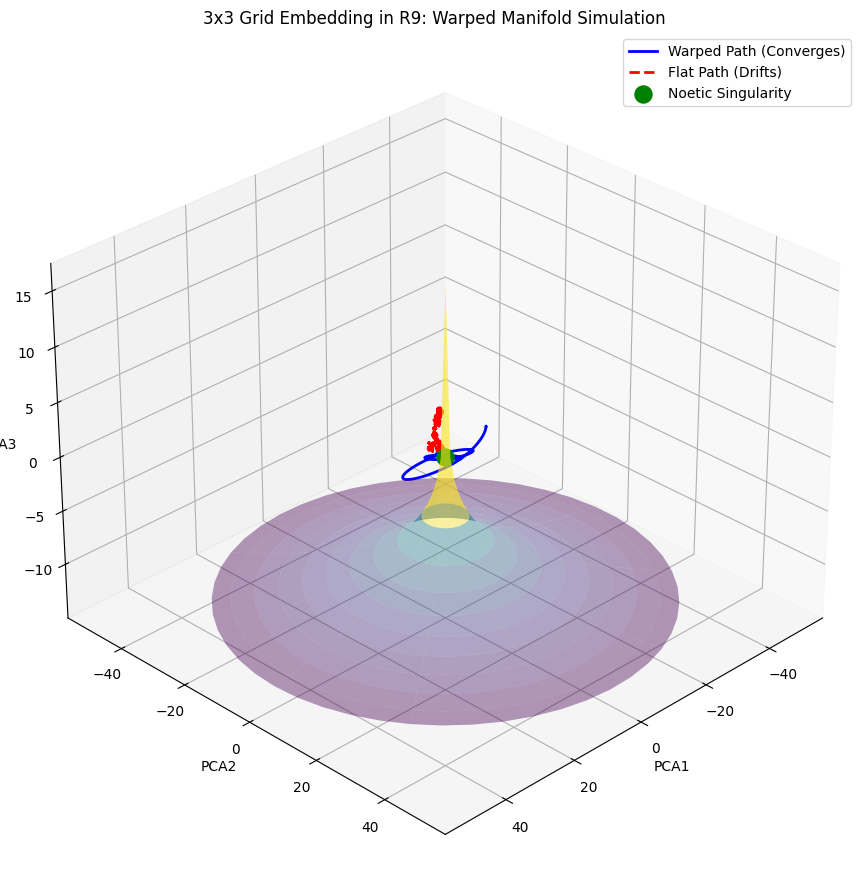

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim

# Step 5: Higher-Dim Embeddings for 3x3 Grid
def create_arc_data_3x3():
    # Sample 3x3 grid flattened to R9
    input_r9 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])  # Initial [1 2 3; 4 5 6; 7 8 9]
    target_r9 = np.array([7, 4, 1, 8, 5, 2, 9, 6, 3])  # 90° clockwise rotation
    return input_r9, target_r9

# Simple PyTorch Autoencoder for structure-preserving embedding
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(9, 16),
            nn.ReLU(),
            nn.Linear(16, 9),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 16),
            nn.ReLU(),
            nn.Linear(16, 9),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Train autoencoder on synthetic 3x3 grids
def train_autoencoder(num_samples=1000, epochs=50, lr=0.001):
    # Generate synthetic data: random 3x3 grids (values 0-9)
    data = np.random.randint(0, 10, size=(num_samples, 9)).astype(np.float32) / 9.0
    data_tensor = torch.tensor(data)

    model = Autoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        _, decoded = model(data_tensor)
        loss = criterion(decoded, data_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    return model

# Project R9 to R3 for visualization
def project_to_r3(r9_data):
    pca = PCA(n_components=3)
    projected = pca.fit_transform(r9_data)
    return projected

# Geodesic equations extended to R9
def geodesic_eqs(y, t, M, r_scale, target, gamma):
    x, dx = y[:9], y[9:]  # R9 position and velocity
    r = np.sqrt(np.sum(x**2)) + 1e-6
    M_eff = M * (1 / (1 + r / r_scale))  # Position-dependent mass
    factor = 1 - 2 * M_eff / r
    # Acceleration: Warping toward origin + pull to target + damping (no rotation yet; added in Step 5)
    d2x = -M_eff * x / r**3 * factor + 0.2 * M_eff * (target - x) / (np.linalg.norm(target - x) + 1e-6) - gamma * dx
    return np.concatenate([dx, d2x])

# Parameters
M = 15.0  # Semantic mass
r_scale = 15.0
gamma = 0.1  # Damping
t = np.linspace(0, 100, 2000)

# Train and embed
autoencoder = train_autoencoder()
input_r9, target_r9 = create_arc_data_3x3()
input_tensor = torch.tensor(input_r9.astype(np.float32) / 9.0).unsqueeze(0)
embedded_input, _ = autoencoder(input_tensor)
embedded_input = embedded_input.detach().numpy().squeeze() * 9.0  # Scale back
embedded_target = target_r9.astype(np.float32)  # For simplicity; in practice, embed target too

# Initial conditions (use embedded input)
y0 = np.concatenate([embedded_input, np.full(9, 0.05)])  # Initial velocity

# Solve for warped path (R9 computation)
sol_well = odeint(geodesic_eqs, y0, t, args=(M, r_scale, embedded_target, gamma))
x_well_r9 = sol_well[:, :9]
x_well_r3 = project_to_r3(x_well_r9)

# Flat space (M=0, no pull)
sol_flat = odeint(geodesic_eqs, y0, t, args=(0, r_scale, embedded_target, gamma))
x_flat_r9 = sol_flat[:, :9]
x_flat_r3 = project_to_r3(x_flat_r9)
np.random.seed(42)
noise = np.random.normal(0, 0.05, size=(len(t), 3))
x_flat_r3 += np.cumsum(noise, axis=0)

# Check convergence
final_pos_well = x_well_r9[-1]
converged = np.all(np.abs(final_pos_well - embedded_target) < 0.1)
print(f"Warped Manifold Converged to Target: {converged}")
print(f"Final Position (Well): {final_pos_well}")
print(f"Target Position: {embedded_target}")

# Funnel surface (logarithmic well, k=50.0)
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0.01, 50, 50)
U, V = np.meshgrid(u, v)
X = V * np.cos(U)
Y = V * np.sin(U)
Z = -50.0 * np.log(V + 1e-6) / (M + 1e-6)  # k=50.0

# Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.4, rstride=5, cstride=5)
ax.plot(x_well_r3[:, 0], x_well_r3[:, 1], x_well_r3[:, 2], 'b-', linewidth=2, label='Warped Path (Converges)')
ax.plot(x_flat_r3[:, 0], x_flat_r3[:, 1], x_flat_r3[:, 2], 'r--', linewidth=2, label='Flat Path (Drifts)')
ax.scatter(0, 0, 0, color='g', s=150, label='Noetic Singularity')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('3x3 Grid Embedding in R9: Warped Manifold Simulation')
ax.legend()
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.savefig(f'warped_manifold_sim.png')
plt.show()

#### Example 2: The capital of France is: Paris, Lyon, Marseille, or Mars

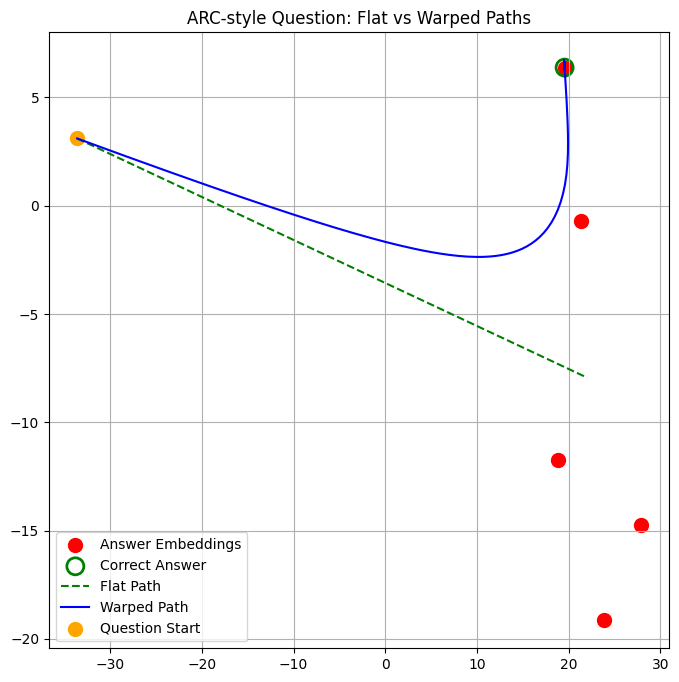

Final distance to the correct answer:
Flat path:    14.528385305822672
Warped path:  0.3533155145611584


In [33]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ------------------------------
# Helper functions
# ------------------------------
def unit(v):
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def semantic_mass(point, centers, strengths):
    """Compute 'force' from answer embeddings"""
    force = np.zeros_like(point)
    for c, s in zip(centers, strengths):
        direction = c - point
        distance_sq = np.sum(direction**2) + 1e-6
        force += direction * s / distance_sq
    return force

def final_distance(path, target):
    """Distance of final point to target answer"""
    return np.linalg.norm(path[-1] - target)

# ------------------------------
# ARC-style setup in R9
# ------------------------------
rng = np.random.default_rng(42)

# Define 5 possible answers (semantic masses)
answers = rng.uniform(0, 20, size=(5, 9))
strengths = np.array([5, 10, 8, 12, 15])  # different "pull" strengths

# Pick one "correct" answer
correct_index = 3
correct_answer = answers[correct_index]

# Start far away
question = rng.uniform(-10, -5, size=9)

# ------------------------------
# Flat path: straight line to avg of all answers
# ------------------------------
avg_answer = np.mean(answers, axis=0)
steps = 200
flat_path = np.array([question + (avg_answer - question) * t/steps for t in range(steps)])

# ------------------------------
# Warped path: geodesic influenced by semantic masses
# ------------------------------
point = question.copy()
warped_path = [point.copy()]
for _ in range(steps):
    f = semantic_mass(point, answers, strengths)
    step = unit(f) * 0.5
    point += step
    warped_path.append(point.copy())
warped_path = np.array(warped_path)

# ------------------------------
# Project to 2D for visualization
# ------------------------------
pca = PCA(n_components=2)
all_points = np.vstack([flat_path, warped_path, answers])
pca.fit(all_points)
flat_2d = pca.transform(flat_path)
warped_2d = pca.transform(warped_path)
answers_2d = pca.transform(answers)
question_2d = pca.transform(question.reshape(1, -1))

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(8, 8))
plt.scatter(answers_2d[:, 0], answers_2d[:, 1], s=100, c='red', label='Answer Embeddings')
plt.scatter(answers_2d[correct_index, 0], answers_2d[correct_index, 1], 
            s=150, facecolors='none', edgecolors='green', linewidths=2, label='Correct Answer')
plt.plot(flat_2d[:, 0], flat_2d[:, 1], 'g--', label='Flat Path')
plt.plot(warped_2d[:, 0], warped_2d[:, 1], 'b-', label='Warped Path')
plt.scatter(question_2d[:, 0], question_2d[:, 1], c='orange', s=100, label='Question Start')
plt.title("ARC-style Question: Flat vs Warped Paths")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Print metrics
# ------------------------------
print("Final distance to the correct answer:")
print("Flat path:   ", final_distance(flat_path, correct_answer))
print("Warped path: ", final_distance(warped_path, correct_answer))


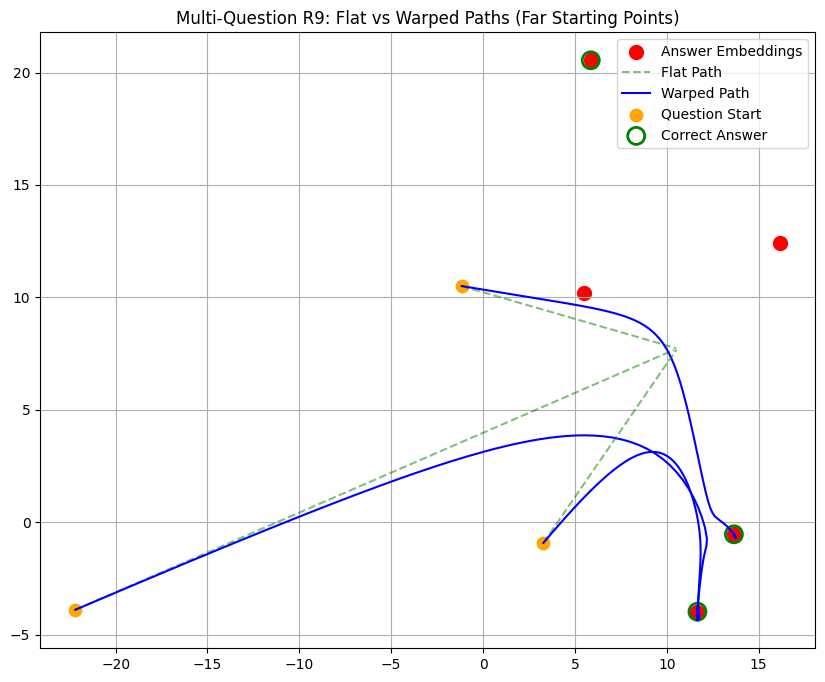

Question 1:
  Distance to correct answer:
    Flat path:    14.63238997001895
    Warped path:  12.293621401221944
Question 2:
  Distance to correct answer:
    Flat path:    11.78856028374419
    Warped path:  12.284769242645693
Question 3:
  Distance to correct answer:
    Flat path:    16.467649095256284
    Warped path:  27.05802075301521


In [46]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ------------------------------
# Helper functions
# ------------------------------
def unit(v):
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def semantic_mass(point, centers, strengths):
    """Compute 'force' from answer embeddings"""
    force = np.zeros_like(point)
    for c, s in zip(centers, strengths):
        direction = c - point
        distance_sq = np.sum(direction**2) + 1e-6
        force += direction * s / distance_sq
    return force

def final_distance(path, target):
    """Distance of final point to target answer"""
    return np.linalg.norm(path[-1] - target)

# ------------------------------
# Multi-question R9 setup
# ------------------------------
rng = np.random.default_rng(42)
num_questions = 3
num_answers = 5
dim = 9
steps = 200

# Define answer embeddings and strengths
answers = rng.uniform(0, 20, size=(num_answers, dim))
strengths = np.array([5, 10, 8, 12, 15])

# Pick correct answers for each question
correct_indices = [3, 1, 4]
correct_answers = answers[correct_indices]

# ------------------------------
# Spread starting points farther apart
# ------------------------------
answer_center = np.mean(answers, axis=0)
questions = answer_center + rng.uniform(-20, 20, size=(num_questions, dim))

# ------------------------------
# Compute flat and warped paths
# ------------------------------
flat_paths = []
warped_paths = []

for q in questions:
    # Flat path: straight to average of all answers
    avg_answer = np.mean(answers, axis=0)
    flat_path = np.array([q + (avg_answer - q) * t/steps for t in range(steps)])
    flat_paths.append(flat_path)
    
    # Warped path: influenced by semantic masses
    point = q.copy()
    warped_path = [point.copy()]
    for _ in range(steps):
        f = semantic_mass(point, answers, strengths)
        step = unit(f) * 0.5
        point += step
        warped_path.append(point.copy())
    warped_paths.append(np.array(warped_path))

# ------------------------------
# Project to 2D for visualization
# ------------------------------
all_points = np.vstack([flat_paths[0], warped_paths[0], answers])
pca = PCA(n_components=2)
pca.fit(all_points)
answers_2d = pca.transform(answers)

flat_paths_2d = [pca.transform(fp) for fp in flat_paths]
warped_paths_2d = [pca.transform(wp) for wp in warped_paths]
questions_2d = [pca.transform(q.reshape(1, -1))[0] for q in questions]
correct_answers_2d = [pca.transform(c.reshape(1,-1))[0] for c in correct_answers]

# ------------------------------
# Plot each question
# ------------------------------
plt.figure(figsize=(10, 8))
plt.scatter(answers_2d[:,0], answers_2d[:,1], s=100, c='red', label='Answer Embeddings')

for i in range(num_questions):
    plt.plot(flat_paths_2d[i][:,0], flat_paths_2d[i][:,1], 'g--', alpha=0.5, label='Flat Path' if i==0 else "")
    plt.plot(warped_paths_2d[i][:,0], warped_paths_2d[i][:,1], 'b-', label='Warped Path' if i==0 else "")
    plt.scatter(questions_2d[i][0], questions_2d[i][1], c='orange', s=80, label='Question Start' if i==0 else "")
    plt.scatter(correct_answers_2d[i][0], correct_answers_2d[i][1], facecolors='none', edgecolors='green', s=150, linewidths=2, label='Correct Answer' if i==0 else "")

plt.title("Multi-Question R9: Flat vs Warped Paths (Far Starting Points)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Print final distances
# ------------------------------
for i in range(num_questions):
    print(f"Question {i+1}:")
    print("  Distance to correct answer:")
    print("    Flat path:   ", final_distance(flat_paths[i], correct_answers[i]))
    print("    Warped path: ", final_distance(warped_paths[i], correct_answers[i]))


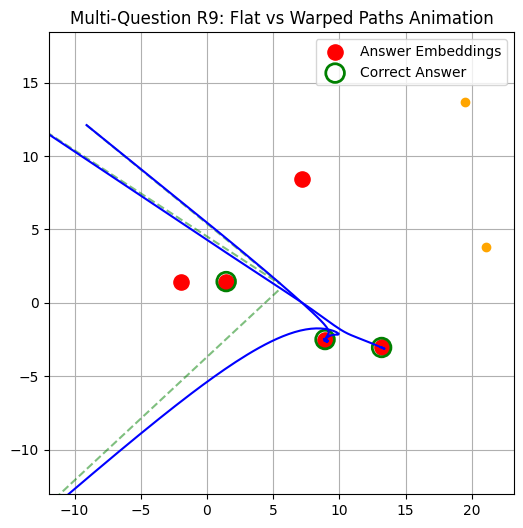

In [62]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ------------------------------
# Helper functions
# ------------------------------
def unit(v):
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def semantic_mass(point, centers, strengths):
    force = np.zeros_like(point)
    for c, s in zip(centers, strengths):
        direction = c - point
        distance_sq = np.sum(direction**2) + 1e-6
        force += direction * s / distance_sq
    return force

# ------------------------------
# Multi-question R9 setup
# ------------------------------
rng = np.random.default_rng(42)
num_questions = 3
num_answers = 5
dim = 9
steps = 150

# Answer embeddings and strengths
answers = rng.uniform(0, 20, size=(num_answers, dim))
strengths = np.array([5, 10, 8, 12, 15])

# Correct answers for each question
correct_indices = [3, 1, 4]
correct_answers = answers[correct_indices]

# Spread starting points far apart
answer_center = np.mean(answers, axis=0)
questions = answer_center + rng.uniform(-20, 20, size=(num_questions, dim))

# ------------------------------
# Precompute flat and warped paths
# ------------------------------
flat_paths = []
warped_paths = []

for q in questions:
    avg_answer = np.mean(answers, axis=0)
    flat_path = np.array([q + (avg_answer - q) * t/steps for t in range(steps)])
    flat_paths.append(flat_path)
    
    point = q.copy()
    warped_path = [point.copy()]
    for _ in range(steps):
        f = semantic_mass(point, answers, strengths)
        point += unit(f) * 0.5
        warped_path.append(point.copy())
    warped_paths.append(np.array(warped_path))

# ------------------------------
# PCA projection for 2D animation
# ------------------------------
all_points = np.vstack([answers] + flat_paths + warped_paths)
pca = PCA(n_components=2)
pca.fit(all_points)
answers_2d = pca.transform(answers)
flat_paths_2d = [pca.transform(fp) for fp in flat_paths]
warped_paths_2d = [pca.transform(wp) for wp in warped_paths]
questions_2d = [pca.transform(q.reshape(1,-1))[0] for q in questions]
correct_answers_2d = [pca.transform(c.reshape(1,-1))[0] for c in correct_answers]

# ------------------------------
# Setup animation
# ------------------------------
fig, ax = plt.subplots(figsize=(6,6))
# Plot answers and correct answers
ax.scatter(answers_2d[:,0], answers_2d[:,1], s=120, c='red', label='Answer Embeddings')
for i, c in enumerate(correct_answers_2d):
    ax.scatter(c[0], c[1], s=180, facecolors='none', edgecolors='green', linewidths=2,
               label='Correct Answer' if i==0 else "")
ax.set_xlim(answers_2d[:,0].min()-10, answers_2d[:,0].max()+10)
ax.set_ylim(answers_2d[:,1].min()-10, answers_2d[:,1].max()+10)
ax.set_title("Multi-Question R9: Flat vs Warped Paths Animation")
ax.grid(True)
ax.legend()

flat_lines = [ax.plot([], [], 'g--', alpha=0.5)[0] for _ in range(num_questions)]
warped_lines = [ax.plot([], [], 'b-')[0] for _ in range(num_questions)]
points_start = [ax.plot(q[0], q[1], 'o', c='orange')[0] for q in questions]

def update(frame):
    for i in range(num_questions):
        flat_lines[i].set_data(flat_paths_2d[i][:frame,0], flat_paths_2d[i][:frame,1])
        warped_lines[i].set_data(warped_paths_2d[i][:frame,0], warped_paths_2d[i][:frame,1])
    return flat_lines + warped_lines

ani = FuncAnimation(fig, update, frames=steps, interval=100, blit=True)
HTML(ani.to_jshtml())
